In [1]:
import requests
import time
import datetime
import pandas as pd
import numpy as np
from pprint import pprint

In [684]:
%pylab inline
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [685]:
output_notebook()

Loading BokehJS ...

In [5]:
import argparse
import ConfigParser

In [45]:
from oauth2client import client

In [140]:
!cat client_secret.json

{"installed":{"client_id":"970111286338-o4a1hnausq73t7pkgcph54jhr964b36r.apps.googleusercontent.com","project_id":"trixandtrax-yt","auth_uri":"https://accounts.google.com/o/oauth2/auth","token_uri":"https://accounts.google.com/o/oauth2/token","auth_provider_x509_cert_url":"https://www.googleapis.com/oauth2/v1/certs","client_secret":"k4kBkAfl06B0q4070lAhhdCG","redirect_uris":["urn:ietf:wg:oauth:2.0:oob","http://localhost"]}}

In [536]:
from oauth2client.client import flow_from_clientsecrets

flow = flow_from_clientsecrets('client_secret.json',
                               scope=["https://www.googleapis.com/auth/youtube.readonly",
  "https://www.googleapis.com/auth/yt-analytics.readonly","https://www.googleapis.com/auth/analytics.readonly" ],
                               redirect_uri='http://localhost')

In [537]:
auth_uri = flow.step1_get_authorize_url()

In [703]:
.7*.7*.7

0.3429999999999999

In [538]:
auth_uri

u'https://accounts.google.com/o/oauth2/auth?scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyt-analytics.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.readonly&redirect_uri=http%3A%2F%2Flocalhost&response_type=code&client_id=970111286338-o4a1hnausq73t7pkgcph54jhr964b36r.apps.googleusercontent.com&access_type=offline'

In [539]:
https://accounts.google.com/o/oauth2/auth?scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyt-analytics.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fanalytics.readonly&redirect_uri=http%3A%2F%2Flocalhost&response_type=code&client_id=970111286338-o4a1hnausq73t7pkgcph54jhr964b36r.apps.googleusercontent.com&access_type=offline 

SyntaxError: invalid syntax (<ipython-input-539-142b869cbc98>, line 1)

In [540]:
code='4/POAnrY43xesN2Lu1A-cjwmeuExkDQxYr69WmRKGnVsc#'

In [541]:
credentials = flow.step2_exchange(code)

In [542]:
from oauth2client.file import Storage

storage = Storage('yt_credentials_file')
storage.put(credentials)



In [521]:
credentials = storage.get()

In [543]:
import httplib2

http = httplib2.Http()
http = credentials.authorize(http)

In [163]:
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"
YOUTUBE_ANALYTICS_API_SERVICE_NAME = "youtubeAnalytics"
YOUTUBE_ANALYTICS_API_VERSION = "v1"

youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,http=http)
youtube_analytics = build(YOUTUBE_ANALYTICS_API_SERVICE_NAME,YOUTUBE_ANALYTICS_API_VERSION, http=http)


In [155]:
channel_id = 'UCSvRAIaavoY6xyR2xQZHiCg'

In [261]:
def run_analytics_report(youtube_analytics, channel_id, options,video_id):
  # Call the Analytics API to retrieve a report. For a list of available
  # reports, see:
  # https://developers.google.com/youtube/analytics/v1/channel_reports
  analytics_query_response = youtube_analytics.reports().query(
    ids="channel==%s" % channel_id,
    metrics=options.metrics(),
    dimensions=options.dimensions(),
    start_date=options.start_date(),
    end_date=options.end_date(),
    filters="video==%s"% video_id
    ##max_results=options.max_results(),
    ##sort=options.sort()
  ).execute()

  print "Analytics Data for Channel %s" % channel_id

  for column_header in analytics_query_response.get("columnHeaders", []):
    print "%-20s" % column_header["name"],
  print

  for row in analytics_query_response.get("rows", []):
    for value in row:
      print "%-20s" % value,
    print
  return analytics_query_response

In [272]:
now = datetime.now()
one_day_ago = (now - timedelta(days=1)).strftime("%Y-%m-%d")
one_week_ago = (now - timedelta(days=365)).strftime("%Y-%m-%d")

class input_builder():
    def __init__(self):
        pass
    def metrics(self):
        return "views,comments,likes,dislikes,shares"
    def dimensions(self):
        return 'month'
    def start_date(self):
        return '2012-01-01'
    def end_date(self):
        return '2016-07-01'
    def max_results(self):
        return 100
    def sort(self):
        return '-views'
    

In [273]:
options = input_builder()

In [268]:
video_id = '_Ar1Bz15izU'

In [ ]:
video_metrics = [run_analytics_report(youtube_analytics, channel_id, options,video_id) for video_id in videos_ids]

Analytics Data for Channel UCSvRAIaavoY6xyR2xQZHiCg
month                views                comments             likes                dislikes             shares              
2015-11              7.0                  0.0                  0.0                  0.0                  0.0                 
2015-12              11.0                 0.0                  0.0                  0.0                  0.0                 
2015-10              7.0                  0.0                  0.0                  0.0                  0.0                 
2016-03              9.0                  0.0                  0.0                  0.0                  0.0                 
2016-02              8.0                  0.0                  0.0                  0.0                  0.0                 
2016-06              8.0                  0.0                  0.0                  0.0                  0.0                 
2015-07              22.0                 0.0                  0.0

In [278]:
len(video_metrics)

1180

In [279]:
video_metrics[0]

{u'columnHeaders': [{u'columnType': u'DIMENSION',
   u'dataType': u'STRING',
   u'name': u'month'},
  {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'views'},
  {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'comments'},
  {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'likes'},
  {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'dislikes'},
  {u'columnType': u'METRIC', u'dataType': u'INTEGER', u'name': u'shares'}],
 u'kind': u'youtubeAnalytics#resultTable',
 u'rows': [[u'2015-11', 7.0, 0.0, 0.0, 0.0, 0.0],
  [u'2015-12', 11.0, 0.0, 0.0, 0.0, 0.0],
  [u'2015-10', 7.0, 0.0, 0.0, 0.0, 0.0],
  [u'2016-03', 9.0, 0.0, 0.0, 0.0, 0.0],
  [u'2016-02', 8.0, 0.0, 0.0, 0.0, 0.0],
  [u'2016-06', 8.0, 0.0, 0.0, 0.0, 0.0],
  [u'2015-07', 22.0, 0.0, 0.0, 0.0, 0.0],
  [u'2016-05', 9.0, 0.0, 0.0, 0.0, 0.0],
  [u'2015-06', 107.0, 0.0, 5.0, 1.0, 2.0],
  [u'2015-08', 21.0, 0.0, 0.0, 0.0, 0.0],
  [u'2015-09', 14.0, 0.0, 0.0, 0.0, 0.0],
  [u'2016-04'

In [495]:
frames = []
for n,video in enumerate(video_metrics):
    if 'rows' in video.keys():
        ##print n,video['rows']
        frame = pd.DataFrame(video['rows'])
        cols = [video['columnHeaders'][i]['name'] for i in range(len(data['columnHeaders']))]
        frame.columns = cols
        frame['id']=videos_ids[n]
        frame.index = frame['id']
        frames.append(frame)

In [496]:
frames[0]

,month,views,comments,likes,dislikes,shares,id
id,,,,,,,
37swjwBALDI,2015-11,7,0,0,0,0,37swjwBALDI
37swjwBALDI,2015-12,11,0,0,0,0,37swjwBALDI
37swjwBALDI,2015-10,7,0,0,0,0,37swjwBALDI
37swjwBALDI,2016-03,9,0,0,0,0,37swjwBALDI
37swjwBALDI,2016-02,8,0,0,0,0,37swjwBALDI
37swjwBALDI,2016-06,8,0,0,0,0,37swjwBALDI
37swjwBALDI,2015-07,22,0,0,0,0,37swjwBALDI
37swjwBALDI,2016-05,9,0,0,0,0,37swjwBALDI
37swjwBALDI,2015-06,107,0,5,1,2,37swjwBALDI


In [497]:
df_vid = pd.concat(frames)

In [487]:
top_vid = df_vid.groupby('id')['views'].sum()

In [488]:
top_vid.sort(ascending=False)

In [509]:
top_vid

id
XyugAQ50KW8    4342
_Ar1Bz15izU    4307
hmsT29187wo    3195
EPt48rcMMZo    2942
ux2SBPKlq5g    2350
1RkLfWimiQA    1684
DPRmQu7-ZbM    1647
NEa8g8nCOAI    1340
IfWhVB6vUgc    1272
_Nqq2IXmOGI     971
aT5s1RfLEfY     910
5a5KX3FG_bc     895
HCKk28jRFSo     864
qWvNXmJeqOI     587
BoSiKMpYvRU     523
xbvfgyiwB6o     521
Rd4S2Np_aoU     521
WBKF7cpNCZE     512
fRhcdl1HD-Y     471
NTU5r4u8X5g     460
2R_ZldpETVE     457
dr5sfJbWmS4     446
ERYxaZIrfJc     438
gAwHee_TEUE     436
nHI0OFGiac8     433
79BBPalbHTU     430
8mc-hJuRFVs     428
hK1lsQ-MjsU     428
nTEtUZ1hanI     405
OFWNDi-E_RU     396
               ... 
6dgsndJkepE       1
Rep7dx-0ics       1
hbgNUEfdpN0       1
e0ngwJvd_ek       1
FvS_DoesDJ4       1
iYNPWBhthHc       1
lgJ_EepiN8Q       1
heueyEH5eZ4       1
iSc2ulMRt1Q       1
qYc1YPhRvgQ       1
awtlA5NNxH0       1
JC7qjcgMEx0       1
emDuyTfCfW4       1
w50c0ZK_Myg       1
vfOETXGO7tM       1
wWX0qBv5mCA       1
g-WoafDeAYA       1
epRhIloRJ5k       1
IFeu3y9MTrE      

In [705]:

def Youtube_Metrics(df, metrics):
    from bokeh.palettes import Spectral11
    p = figure(x_axis_type="datetime", width=700, height=300)
    for i,metric in enumerate(metrics):
        x = pd.to_datetime(df.groupby('month')[metric].sum().index)
        y = df.groupby('month')[metric].sum().values
        p.line(x,y,color=Spectral11[i*2], legend=metric)


    p.title = "Youtube Metrics"
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Metrics'
    p.legend.orientation = "top_left"
    return p



In [704]:
metrics = ['views', 'comments','shares','likes']
show(Youtube_Metrics(df_vid,metrics))

/root/anaconda2/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


TypeError: datetime.timedelta(925) is not JSON serializable

In [657]:
x = pd.to_datetime(df_vid.groupby('month')['views'].sum().index)
y = df_vid.groupby('month')['views'].sum().values

In [669]:
y

array([   542.,    476.,    135.,    158.,    232.,    120.,   1046.,
         8250.,   3315.,    871.,    668.,    886.,    617.,    692.,
          679.,    552.,    484.,    622.,   1458.,   1375.,    450.,
          302.,    276.,    255.,    409.,    799.,    554.,    590.,
         1953.,   2295.,    943.,   8453.,   2362.,   1112.,   1206.,
         1308.,   1309.,   1528.,  13242.,   3316.,   2990.,   2034.,
         2195.,   2632.,   1360.,   1290.,   1346.,   1131.,   1169.,
         1579.,   3067.])

In [707]:
df.groupby('month')['views'].sum()

month
2012-04      542
2012-05      476
2012-06      135
2012-07      158
2012-08      232
2012-09      120
2012-10     1046
2012-11     8250
2012-12     3315
2013-01      871
2013-02      668
2013-03      886
2013-04      617
2013-05      692
2013-06      679
2013-07      552
2013-08      484
2013-09      622
2013-10     1458
2013-11     1375
2013-12      450
2014-01      302
2014-02      276
2014-03      255
2014-04      409
2014-05      799
2014-06      554
2014-07      590
2014-08     1953
2014-09     2295
2014-10      943
2014-11     8453
2014-12     2362
2015-01     1112
2015-02     1206
2015-03     1308
2015-04     1309
2015-05     1528
2015-06    13242
2015-07     3316
2015-08     2990
2015-09     2034
2015-10     2195
2015-11     2632
2015-12     1360
2016-01     1290
2016-02     1346
2016-03     1131
2016-04     1169
2016-05     1579
2016-06     3067
Name: views, dtype: float64

In [670]:
p = figure(x_axis_type="datetime", width=700, height=300)
p.line(x,y,color='#FF0000', legend='views')
show(p)


TypeError: datetime.timedelta(925) is not JSON serializable

In [285]:
df_vid1 = pd.DataFrame(video_metrics[1]['rows'])
cols = [video_metrics[1]['columnHeaders'][i]['name'] for i in range(len(data['columnHeaders']))]
df_vid1.columns = cols
df_vid1['id']=videos_ids[1]
df_vid1.index = df_vid1['id']

In [286]:
df_vid1

,month,views,comments,likes,dislikes,shares,id
id,,,,,,,
V-tdAK29wkg,2014-07,2,0,0,0,0,V-tdAK29wkg


In [349]:
df= df_vid.join(df_videos)

In [466]:
df['date_month']= pd.Index(df['month']).to_datetime() + pd.offsets.MonthEnd(1)

In [467]:
df['days']=(pd.to_datetime(df['date_month'])-pd.to_datetime(df['created_date']))

In [474]:
df['days']=(df['days'].values.astype('timedelta64[D]')/ np.timedelta64(1, 'D')).astype(int)

In [477]:
df['days']

-3YsWHCdRO8     925
-3YsWHCdRO8     833
-3YsWHCdRO8      13
-3YsWHCdRO8     256
-3YsWHCdRO8     317
-3YsWHCdRO8     378
-3YsWHCdRO8     287
-3YsWHCdRO8      75
-3YsWHCdRO8     743
-3YsWHCdRO8     103
-3YsWHCdRO8     348
-3YsWHCdRO8      44
-3YsWHCdRO8     134
-3YsWHCdRO8     164
-3YsWHCdRO8     468
-3YsWHCdRO8     529
-98IgFmrcBk     202
-98IgFmrcBk     141
-98IgFmrcBk     262
-98IgFmrcBk     384
-98IgFmrcBk      49
-98IgFmrcBk      18
-98IgFmrcBk      80
-98IgFmrcBk     110
-98IgFmrcBk     233
-JqKxvgKvcI     447
-JqKxvgKvcI     264
-JqKxvgKvcI     417
-JqKxvgKvcI     172
-JqKxvgKvcI     203
               ... 
zvke9oU9jz0     270
zvke9oU9jz0     726
zvke9oU9jz0      86
zvke9oU9jz0    1213
zvke9oU9jz0      27
zvke9oU9jz0     331
zvke9oU9jz0     178
zvke9oU9jz0     451
zvke9oU9jz0    1000
zvke9oU9jz0    1243
zzKwGO2z4fo    1041
zzKwGO2z4fo      68
zzKwGO2z4fo     160
zzKwGO2z4fo     586
zzKwGO2z4fo      38
zzKwGO2z4fo      99
zzKwGO2z4fo     798
zzKwGO2z4fo     191
zzKwGO2z4fo     130


In [641]:
x = df['days'].values
y = df['views'].values
p = figure( width=700, height=300)
p.circle(x,y,color='#FF0000', legend='views')
show(p)

TypeError: datetime.timedelta(925) is not JSON serializable

In [402]:
import pandas
import numpy
import datetime
from pandas.tseries.offsets import Day, MonthEnd

df['EndOfMonth']=df['date_month'].values.to_period('M')

AttributeError: 'numpy.ndarray' object has no attribute 'to_period'

In [405]:
df['date_month'].dt.days_in_month

-3YsWHCdRO8    31
-3YsWHCdRO8    28
-3YsWHCdRO8    30
-3YsWHCdRO8    31
-3YsWHCdRO8    30
-3YsWHCdRO8    30
-3YsWHCdRO8    31
-3YsWHCdRO8    31
-3YsWHCdRO8    30
-3YsWHCdRO8    28
-3YsWHCdRO8    31
-3YsWHCdRO8    31
-3YsWHCdRO8    31
-3YsWHCdRO8    30
-3YsWHCdRO8    28
-3YsWHCdRO8    30
-98IgFmrcBk    31
-98IgFmrcBk    31
-98IgFmrcBk    29
-98IgFmrcBk    30
-98IgFmrcBk    31
-98IgFmrcBk    30
-98IgFmrcBk    31
-98IgFmrcBk    30
-98IgFmrcBk    31
-JqKxvgKvcI    30
-JqKxvgKvcI    31
-JqKxvgKvcI    31
-JqKxvgKvcI    28
-JqKxvgKvcI    31
               ..
zvke9oU9jz0    31
zvke9oU9jz0    30
zvke9oU9jz0    28
zvke9oU9jz0    31
zvke9oU9jz0    31
zvke9oU9jz0    31
zvke9oU9jz0    31
zvke9oU9jz0    28
zvke9oU9jz0    31
zvke9oU9jz0    30
zzKwGO2z4fo    28
zzKwGO2z4fo    30
zzKwGO2z4fo    30
zzKwGO2z4fo    30
zzKwGO2z4fo    31
zzKwGO2z4fo    31
zzKwGO2z4fo    30
zzKwGO2z4fo    31
zzKwGO2z4fo    31
zzKwGO2z4fo    31
zzKwGO2z4fo    31
zzKwGO2z4fo    30
zzKwGO2z4fo    28
zzKwGO2z4fo    31
zzKwGO2z4f

In [701]:
pd.DataFrame(df.groupby('date_month')['views'].sum()).to_csv('video_views.csv')

In [290]:
pd.concat([df_vid, df_vid1])

,month,views,comments,likes,dislikes,shares,id
id,,,,,,,
37swjwBALDI,2015-11,7,0,0,0,0,37swjwBALDI
37swjwBALDI,2015-12,11,0,0,0,0,37swjwBALDI
37swjwBALDI,2015-10,7,0,0,0,0,37swjwBALDI
37swjwBALDI,2016-03,9,0,0,0,0,37swjwBALDI
37swjwBALDI,2016-02,8,0,0,0,0,37swjwBALDI
37swjwBALDI,2016-06,8,0,0,0,0,37swjwBALDI
37swjwBALDI,2015-07,22,0,0,0,0,37swjwBALDI
37swjwBALDI,2016-05,9,0,0,0,0,37swjwBALDI
37swjwBALDI,2015-06,107,0,5,1,2,37swjwBALDI


In [226]:
channels_response = youtube.channels().list(
  mine=True,
  part="contentDetails"
).execute()

In [228]:
pprint(channels_response)

{u'etag': u'"5g01s4-wS2b4VpScndqCYc5Y-8k/cfEjh8LX6ErT1AQzfoii_T2QbS8"',
 u'items': [{u'contentDetails': {u'relatedPlaylists': {u'favorites': u'FLSvRAIaavoY6xyR2xQZHiCg',
                                                       u'likes': u'LLSvRAIaavoY6xyR2xQZHiCg',
                                                       u'uploads': u'UUSvRAIaavoY6xyR2xQZHiCg',
                                                       u'watchHistory': u'HLSvRAIaavoY6xyR2xQZHiCg',
                                                       u'watchLater': u'WLSvRAIaavoY6xyR2xQZHiCg'}},
             u'etag': u'"5g01s4-wS2b4VpScndqCYc5Y-8k/mD3dSbS1QBTSxrjS_O02z8Vg6tk"',
             u'id': u'UCSvRAIaavoY6xyR2xQZHiCg',
             u'kind': u'youtube#channel'}],
 u'kind': u'youtube#channelListResponse',
 u'pageInfo': {u'resultsPerPage': 1, u'totalResults': 1}}


In [253]:
for channel in channels_response["items"]:
  # From the API response, extract the playlist ID that identifies the list
  # of videos uploaded to the authenticated user's channel.
    uploads_list_id = channel["contentDetails"]["relatedPlaylists"]["uploads"]

    print "Videos in list %s" % uploads_list_id

  # Retrieve the list of videos uploaded to the authenticated user's channel.
    playlistitems_list_request = youtube.playlistItems().list(
playlistId=uploads_list_id,
part="snippet",
maxResults=50
  )
    video_title_dict = {}
    video_date_dict = {}
    video_description_dict={}
    while playlistitems_list_request:
        playlistitems_list_response = playlistitems_list_request.execute()

    # Print information about each video.
        for playlist_item in playlistitems_list_response["items"]:
            title = playlist_item["snippet"]["title"]
            created = playlist_item["snippet"]["publishedAt"]
            description =  playlist_item["snippet"]["description"]
            video_id = playlist_item["snippet"]["resourceId"]["videoId"]
            video_title_dict[video_id]=title
            video_date_dict[video_id]=created
            video_description_dict[video_id]=description
            print "%s (%s)" % (title, video_id)

        playlistitems_list_request = youtube.playlistItems().list_next(
      playlistitems_list_request, playlistitems_list_response)

    print

Videos in list UUSvRAIaavoY6xyR2xQZHiCg
48 Talento baile Colegio IEA 2016 (DyYjjm7C4x4)
Vilan Talento Trax Colegio IEA 2016 (iOeDKtaLqkM)
Valeria Carmona Talento Trax Colegio IEA 2016 (2k6cTK1r1cA)
The Six Direction Talento Trax Colegio IEA 2016 (MXz7Yp6CLJ8)
Tamayo Talento Freestyle Colegio IEA 2016 (O7mVGtQ9_2A)
SuperHeroes Trix Talento Freestyle Colegio IEA 2016 (4DdK_hFb9P0)
Ricardo Padrino Zona Trax Colegio IEA 2016 (aGWmc4pV_Zg)
Los Reparadores Talento Trax Colegio IEA 2016 (FtI6tCsctIo)
Los Macarenitos Talento baile Colegio IEA 2016 (8opOIeXEb7c)
Los Fieles Talento Freestyle Colegio IEA 2016 (CO91_XtDx6k)
Los Fieles Talento baile Colegio IEA 2016 (6HTchxmaakY)
Leopoldo Quintero Talento Trax Colegio IEA 2016 (bruVp9c68xk)
Las Chicas Del Can Talento Baile Colegio Champagnat (EjONiAUyrTo)
Jesus Correa Talento Freestyle Colegio IEA 2016 (u8LCOGlb6b0)
Isabella GuzmanTalento Trax Colegio IEA 2016 (aTuENwdbwt4)
Isabella & Maite Talento Trax Colegio IEA 2016 (MZ064F8xnBw)
Gerardo Sousa 

In [234]:
len(video_date_dict)

1180

In [236]:
video_date_dict

{u'37swjwBALDI': u'2015-06-07T20:18:38.000Z',
 u'V-tdAK29wkg': u'2014-07-11T02:28:47.000Z',
 u'oTMRZWYOCl4': u'2014-08-20T15:26:53.000Z',
 u'YmLLR_IBFjk': u'2014-11-17T02:43:24.000Z',
 u'e9MKuCc0Ux4': u'2012-04-22T04:40:57.000Z',
 u'FS5VE_Rl6VI': u'2014-11-17T02:43:33.000Z',
 u'M__uPAyxzw4': u'2012-11-30T16:29:04.000Z',
 u'ziNSuv6O9v8': u'2014-11-06T16:33:06.000Z',
 u'TyrRIXsda5c': u'2014-11-11T06:38:55.000Z',
 u'GK3h1XuO-3w': u'2015-06-08T21:49:53.000Z',
 u'hetwExY9sP8': u'2014-09-04T17:00:26.000Z',
 u'nbhwxvYODRk': u'2014-09-06T14:17:54.000Z',
 u'gRSjDSlczKk': u'2016-05-01T18:52:25.000Z',
 u'G7FJSAwjPzQ': u'2014-09-06T14:24:12.000Z',
 u'M1W64PP1y_w': u'2015-06-11T15:17:50.000Z',
 u'DPRmQu7-ZbM': u'2012-11-07T14:53:15.000Z',
 u'qJKJalJgil4': u'2015-06-15T20:20:30.000Z',
 u'rUNUyOVAnJg': u'2012-11-01T21:23:30.000Z',
 u'vnb_5B2gRII': u'2014-11-11T06:38:57.000Z',
 u'UB_g8jKLkLM': u'2014-11-10T10:24:10.000Z',
 u'ERYxaZIrfJc': u'2015-06-15T20:20:30.000Z',
 u'Rd4S2Np_aoU': u'2012-10-23T21:5

In [242]:
df_video = pd.DataFrame.from_dict(video_date_dict, orient='index', dtype=datetime64)

In [244]:
df_title = pd.DataFrame.from_dict(video_title_dict, orient='index', dtype=None)

In [254]:
df_description = pd.DataFrame.from_dict(video_description_dict, orient='index', dtype=None)

In [255]:
df_title.columns = ['title']
df_video.columns = ['created_date']
df_description.columns=['description']

In [270]:
df_videos = df_title.join(df_video).join(df_description)

In [271]:
df_videos['created_date'].min()

Timestamp('2012-04-18 22:35:18')

In [347]:
df_videos

,title,created_date,description
37swjwBALDI,Yesthin Perez -Talento Baile - Colegio San Vic...,2015-06-07 20:18:38,
V-tdAK29wkg,IMG 6033,2014-07-11 02:28:47,
oTMRZWYOCl4,TRIX Roberto Lopez. DOMINIO BASKET,2014-08-20 15:26:53,
YmLLR_IBFjk,Premiación Artes Visuales Simón Bolívar II,2014-11-17 02:43:24,
e9MKuCc0Ux4,IEA - TRIX - Indoboard.MOV,2012-04-22 04:40:57,Los mejores talentos TRIXANDTRAX de Colegio el...
FS5VE_Rl6VI,Veronica Talento Trix IEA YouTube sharing,2014-11-17 02:43:33,
M__uPAyxzw4,ANUNCIAN GANADOR DE WAYRA A TRIXANDTRAX!!,2012-11-30 16:29:04,HACE UN AÑO comenzó nuestro journey en WAYRA V...
ziNSuv6O9v8,Darwin & Erso - Talento Artes Visuales - CEAPUCV,2014-11-06 16:33:06,
TyrRIXsda5c,Andreina Talento Trix IEA YouTube sharing,2014-11-11 06:38:55,
GK3h1XuO-3w,TALENTO ZONA BAILE NELIA BRACHO CHAMPAGNAT,2015-06-08 21:49:53,


In [274]:
videos_ids = df_videos.index

In [275]:
videos_ids

Index([u'37swjwBALDI', u'V-tdAK29wkg', u'oTMRZWYOCl4', u'YmLLR_IBFjk',
       u'e9MKuCc0Ux4', u'FS5VE_Rl6VI', u'M__uPAyxzw4', u'ziNSuv6O9v8',
       u'TyrRIXsda5c', u'GK3h1XuO-3w', 
       ...
       u'NCkR35FUi5A', u'DUvvIOmjEzk', u'0jyWLX3lB-k', u'L02BN1zq2So',
       u'khP_YkIlOvc', u'eaDLKHbFaE8', u'SJ8p4XOlAKM', u'jqV2Mk-jAIE',
       u'9XXetw5w_-g', u'SKwDRETmJtY'],
      dtype='object', length=1180)

In [202]:
pprint(data)

{u'columnHeaders': [{u'columnType': u'DIMENSION',
                     u'dataType': u'STRING',
                     u'name': u'video'},
                    {u'columnType': u'METRIC',
                     u'dataType': u'INTEGER',
                     u'name': u'views'},
                    {u'columnType': u'METRIC',
                     u'dataType': u'INTEGER',
                     u'name': u'comments'},
                    {u'columnType': u'METRIC',
                     u'dataType': u'INTEGER',
                     u'name': u'likes'},
                    {u'columnType': u'METRIC',
                     u'dataType': u'INTEGER',
                     u'name': u'dislikes'},
                    {u'columnType': u'METRIC',
                     u'dataType': u'INTEGER',
                     u'name': u'shares'}],
 u'kind': u'youtubeAnalytics#resultTable',
 u'rows': [[u'_Ar1Bz15izU', 1146.0, 1.0, 9.0, 0.0, 2.0],
           [u'1RkLfWimiQA', 926.0, 11.0, 8.0, 7.0, 17.0],
           [u'5a5KX3FG_bc', 

In [214]:
df = pd.DataFrame(data['rows'])

In [222]:
cols = [data['columnHeaders'][i]['name'] for i in range(len(data['columnHeaders']))]

In [223]:
df.columns = cols

In [224]:
df

,video,views,comments,likes,dislikes,shares
0,_Ar1Bz15izU,1146,1,9,0,2
1,1RkLfWimiQA,926,11,8,7,17
2,5a5KX3FG_bc,499,0,8,0,5
3,HCKk28jRFSo,448,0,2,1,0
4,_Nqq2IXmOGI,399,1,3,0,3
5,XyugAQ50KW8,352,0,0,0,1
6,EPt48rcMMZo,288,0,0,0,1
7,ERYxaZIrfJc,286,0,3,0,0
8,hmsT29187wo,286,0,1,0,2
9,fRhcdl1HD-Y,285,1,8,0,0


In [6]:
config = ConfigParser.ConfigParser()
config.read('.ttapis.cfg')

['.ttapis.cfg']

In [7]:
config.sections()

['Eventbrite', 'Youtube', 'Twitter']

In [8]:
yt_config = dict(config.items('Youtube'))

In [34]:
yt_config['client_secret']

'g9D42Jyvw63AbY9YN-4qPRKj'

In [10]:
CLIENT_SECRETS_FILE = ".ytapis.cfg"

In [11]:
CLIENT_SECRETS_FILE

'.ytapis.cfg'

In [21]:
os.path.dirname(os.path.abspath(".ytapis.cfg"))

'/root/home/datacourse/projects/trixandtrax'

In [141]:
from datetime import datetime, timedelta
import httplib2
import os
import sys


from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from oauth2client.tools import argparser
from oauth2client.client import flow_from_clientsecrets
from oauth2client.file import Storage
from oauth2client.tools import argparser, run_flow


# The CLIENT_SECRETS_FILE variable specifies the name of a file that contains
# the OAuth 2.0 information for this application, including its client_id and
# client_secret. You can acquire an OAuth 2.0 client ID and client secret from
# the Google Developers Console at
# https://console.developers.google.com/.
# Please ensure that you have enabled the YouTube Data and YouTube Analytics
# APIs for your project.
# For more information about using OAuth2 to access the YouTube Data API, see:
#   https://developers.google.com/youtube/v3/guides/authentication
# For more information about the client_secrets.json file format, see:
#   https://developers.google.com/api-client-library/python/guide/aaa_client_secrets
CLIENT_SECRETS_FILE = "client_secrets.json"

# These OAuth 2.0 access scopes allow for read-only access to the authenticated
# user's account for both YouTube Data API resources and YouTube Analytics Data.
YOUTUBE_SCOPES = ["https://www.googleapis.com/auth/youtube.readonly",
  "https://www.googleapis.com/auth/yt-analytics.readonly"]
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"
YOUTUBE_ANALYTICS_API_SERVICE_NAME = "youtubeAnalytics"
YOUTUBE_ANALYTICS_API_VERSION = "v1"

# This variable defines a message to display if the CLIENT_SECRETS_FILE is
# missing.
MISSING_CLIENT_SECRETS_MESSAGE = """
WARNING: Please configure OAuth 2.0

To make this sample run you will need to populate the client_secrets.json file
found at:

   %s

with information from the Developers Console
https://console.developers.google.com/

For more information about the client_secrets.json file format, please visit:
https://developers.google.com/api-client-library/python/guide/aaa_client_secrets
""" % os.path.abspath(os.path.join(os.path.dirname("client_secrets.json"),
                                   CLIENT_SECRETS_FILE))


def get_authenticated_services(args):
  flow = flow_from_clientsecrets(CLIENT_SECRETS_FILE,
    scope=" ".join(YOUTUBE_SCOPES),
    message=MISSING_CLIENT_SECRETS_MESSAGE)

  storage = Storage("%s-oauth2.json" % sys.argv[0])
  credentials = storage.get()

  if credentials is None or credentials.invalid:
    credentials = run_flow(flow, storage, args)

  http = credentials.authorize(httplib2.Http())

  youtube = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION,
    http=http)
  youtube_analytics = build(YOUTUBE_ANALYTICS_API_SERVICE_NAME,
    YOUTUBE_ANALYTICS_API_VERSION, http=http)

  return (youtube, youtube_analytics)

def get_channel_id(youtube):
  channels_list_response = youtube.channels().list(
    mine=True,
    part="id"
  ).execute()

  return channels_list_response["items"][0]["id"]

def run_analytics_report(youtube_analytics, channel_id, options):
  # Call the Analytics API to retrieve a report. For a list of available
  # reports, see:
  # https://developers.google.com/youtube/analytics/v1/channel_reports
  analytics_query_response = youtube_analytics.reports().query(
    ids="channel==%s" % channel_id,
    metrics=options.metrics,
    dimensions=options.dimensions,
    start_date=options.start_date,
    end_date=options.end_date,
    max_results=options.max_results,
    sort=options.sort
  ).execute()

  print "Analytics Data for Channel %s" % channel_id

  for column_header in analytics_query_response.get("columnHeaders", []):
    print "%-20s" % column_header["name"],
  print

  for row in analytics_query_response.get("rows", []):
    for value in row:
      print "%-20s" % value,
    print

if __name__ == "__main__":
  now = datetime.now()
  one_day_ago = (now - timedelta(days=1)).strftime("%Y-%m-%d")
  one_week_ago = (now - timedelta(days=7)).strftime("%Y-%m-%d")

  argparser.add_argument("--metrics", help="Report metrics",
                         default="views,comments,likes,dislikes,shares")
  argparser.add_argument("--dimensions", help="Report dimensions",
    default="video")
  argparser.add_argument("--start-date", default=one_week_ago,
    help="Start date, in YYYY-MM-DD format")
  argparser.add_argument("--end-date", default=one_day_ago,
    help="End date, in YYYY-MM-DD format")
  argparser.add_argument("--max-results", help="Max results", default=10)
  argparser.add_argument("--sort", help="Sort order", default="-views")
  args = argparser.parse_args()

  (youtube, youtube_analytics) = get_authenticated_services(args)
  try:
    channel_id = get_channel_id(youtube)
    run_analytics_report(youtube_analytics, channel_id, args)
  except HttpError, e:
    print "An HTTP error %d occurred:\n%s" % (e.resp.status, e.content)
    %tb

ArgumentError: argument --metrics: conflicting option string(s): --metrics

In [513]:
"""Hello Analytics Reporting API V4."""

import argparse

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import httplib2
from oauth2client import client
from oauth2client import file
from oauth2client import tools

SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
DISCOVERY_URI = ('https://analyticsreporting.googleapis.com/$discovery/rest')
CLIENT_SECRETS_PATH = 'client_secret.json' # Path to client_secrets.json file.
VIEW_ID = '66160762'


def initialize_analyticsreporting():
  """Initializes the analyticsreporting service object.

  Returns:
    analytics an authorized analyticsreporting service object.
  """
  # Parse command-line arguments.
  parser = argparse.ArgumentParser(
      formatter_class=argparse.RawDescriptionHelpFormatter,
      parents=[tools.argparser])
  flags = parser.parse_args([])

  # Set up a Flow object to be used if we need to authenticate.
  flow = client.flow_from_clientsecrets(
      CLIENT_SECRETS_PATH, scope=SCOPES,
      message=tools.message_if_missing(CLIENT_SECRETS_PATH))

  # Prepare credentials, and authorize HTTP object with them.
  # If the credentials don't exist or are invalid run through the native client
  # flow. The Storage object will ensure that if successful the good
  # credentials will get written back to a file.
  storage = file.Storage('analyticsreporting.dat')
  credentials = storage.get()
  if credentials is None or credentials.invalid:
    credentials = tools.run_flow(flow, storage, flags)
  http = credentials.authorize(http=httplib2.Http())

  # Build the service object.
  analytics = build('analytics', 'v4', http=http, discoveryServiceUrl=DISCOVERY_URI)

  return analytics

def get_report(analytics):
  # Use the Analytics Service Object to query the Analytics Reporting API V4.
  return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': '7daysAgo', 'endDate': 'today'}],
          'metrics': [{'expression': 'ga:sessions'}]
        }]
      }
  ).execute()


def print_response(response):
  """Parses and prints the Analytics Reporting API V4 response"""

  for report in response.get('reports', []):
    columnHeader = report.get('columnHeader', {})
    dimensionHeaders = columnHeader.get('dimensions', [])
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
    rows = report.get('data', {}).get('rows', [])

    for row in rows:
      dimensions = row.get('dimensions', [])
      dateRangeValues = row.get('metrics', [])

      for header, dimension in zip(dimensionHeaders, dimensions):
        print header + ': ' + dimension

      for i, values in enumerate(dateRangeValues):
        print 'Date range (' + str(i) + ')'
        for metricHeader, value in zip(metricHeaders, values.get('values')):
          print metricHeader.get('name') + ': ' + value


def main():

  analytics = initialize_analyticsreporting()
  response = get_report(analytics)
  print_response(response)

if __name__ == '__main__':
  main()

KeyboardInterrupt: 

In [547]:
"""Hello Analytics Reporting API V4."""

import argparse

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import httplib2
from oauth2client import client
from oauth2client import file
from oauth2client import tools

SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
DISCOVERY_URI = ('https://analyticsreporting.googleapis.com/$discovery/rest')
CLIENT_SECRETS_PATH = 'client_secret.json' # Path to client_secrets.json file.
VIEW_ID = '66183503'


In [515]:
def initialize_analyticsreporting():
  """Initializes the analyticsreporting service object.

  Returns:
    analytics an authorized analyticsreporting service object.
  """
  # Parse command-line arguments.
  parser = argparse.ArgumentParser(
      formatter_class=argparse.RawDescriptionHelpFormatter,
      parents=[tools.argparser])
  flags = parser.parse_args([])

  # Set up a Flow object to be used if we need to authenticate.
  flow = client.flow_from_clientsecrets(
      CLIENT_SECRETS_PATH, scope=SCOPES,
      message=tools.message_if_missing(CLIENT_SECRETS_PATH))

  # Prepare credentials, and authorize HTTP object with them.
  # If the credentials don't exist or are invalid run through the native client
  # flow. The Storage object will ensure that if successful the good
  # credentials will get written back to a file.
  storage = file.Storage('analyticsreporting.dat')
  credentials = storage.get()
  if credentials is None or credentials.invalid:
    credentials = tools.run_flow(flow, storage, flags)
  http = credentials.authorize(http=httplib2.Http())

  # Build the service object.
  analytics = build('analytics', 'v4', http=http, discoveryServiceUrl=DISCOVERY_URI)

  return analytics

In [548]:
analytics = build('analytics', 'v4', http=http, discoveryServiceUrl=DISCOVERY_URI)

In [574]:
def get_report(analytics):
  # Use the Analytics Service Object to query the Analytics Reporting API V4.
  return analytics.reports().batchGet(
      body={
        'reportRequests': [
        {
          'viewId': VIEW_ID,
          'dateRanges': [{'startDate': '2012-01-01', 'endDate': '2016-07-01'}],
          'metrics': [{'expression': 'ga:users'},{'expression': 'ga:sessions'} ],
                    "dimensions": [
        {
          "name":"ga:yearMonth"
        }]
        }]
      }
  ).execute()

In [553]:
def print_response(response):
  """Parses and prints the Analytics Reporting API V4 response"""

  for report in response.get('reports', []):
    columnHeader = report.get('columnHeader', {})
    dimensionHeaders = columnHeader.get('dimensions', [])
    metricHeaders = columnHeader.get('metricHeader', {}).get('metricHeaderEntries', [])
    rows = report.get('data', {}).get('rows', [])

    for row in rows:
      dimensions = row.get('dimensions', [])
      dateRangeValues = row.get('metrics', [])

      for header, dimension in zip(dimensionHeaders, dimensions):
        print header + ': ' + dimension

      for i, values in enumerate(dateRangeValues):
        print 'Date range (' + str(i) + ')'
        for metricHeader, value in zip(metricHeaders, values.get('values')):
          print metricHeader.get('name') + ': ' + value

In [575]:
response = get_report(analytics)
print_response(response)

ga:yearMonth: 201211
Date range (0)
ga:users: 189
ga:sessions: 697
ga:yearMonth: 201212
Date range (0)
ga:users: 193
ga:sessions: 696
ga:yearMonth: 201301
Date range (0)
ga:users: 112
ga:sessions: 408
ga:yearMonth: 201302
Date range (0)
ga:users: 63
ga:sessions: 202
ga:yearMonth: 201303
Date range (0)
ga:users: 54
ga:sessions: 141
ga:yearMonth: 201304
Date range (0)
ga:users: 34
ga:sessions: 119
ga:yearMonth: 201305
Date range (0)
ga:users: 59
ga:sessions: 146
ga:yearMonth: 201306
Date range (0)
ga:users: 75
ga:sessions: 116
ga:yearMonth: 201307
Date range (0)
ga:users: 71
ga:sessions: 111
ga:yearMonth: 201308
Date range (0)
ga:users: 63
ga:sessions: 94
ga:yearMonth: 201309
Date range (0)
ga:users: 30
ga:sessions: 46
ga:yearMonth: 201310
Date range (0)
ga:users: 32
ga:sessions: 51
ga:yearMonth: 201311
Date range (0)
ga:users: 16
ga:sessions: 35
ga:yearMonth: 201312
Date range (0)
ga:users: 19
ga:sessions: 22
ga:yearMonth: 201401
Date range (0)
ga:users: 17
ga:sessions: 24
ga:yearMonth:

In [577]:
pprint(response)

{u'reports': [{u'columnHeader': {u'dimensions': [u'ga:yearMonth'],
                                 u'metricHeader': {u'metricHeaderEntries': [{u'name': u'ga:users',
                                                                             u'type': u'INTEGER'},
                                                                            {u'name': u'ga:sessions',
                                                                             u'type': u'INTEGER'}]}},
               u'data': {u'isDataGolden': True,
                         u'maximums': [{u'values': [u'7374', u'10143']}],
                         u'minimums': [{u'values': [u'0', u'0']}],
                         u'rowCount': 45,
                         u'rows': [{u'dimensions': [u'201211'],
                                    u'metrics': [{u'values': [u'189',
                                                              u'697']}]},
                                   {u'dimensions': [u'201212'],
                            

In [594]:
pd.DataFrame([pd.Series([response['reports'][0]['data']['rows'][month]['dimensions'] for month in response['reports'][0]['data']['rows']] ), 
             pd.Series([response['reports'][0]['data']['rows'][month]['metrics']['values'] for month in response['reports'][0]['data']['rows']])])

TypeError: list indices must be integers, not dict

In [593]:
pprint(response['reports'][0]['data']['rows'][0])

{u'dimensions': [u'201211'], u'metrics': [{u'values': [u'189', u'697']}]}


In [619]:
month_year =pd.Series([response['reports'][0]['data']['rows'][i]['dimensions'][0] for i in range(len( response['reports'][0]['data']['rows']))])

In [600]:
pprint(response['reports'][0]['data']['rows'][0]['dimensions'][0])

u'201211'


In [620]:
users = pd.Series([response['reports'][0]['data']['rows'][i]['metrics'][0]['values'][0] for i in range(len( response['reports'][0]['data']['rows']))])

In [621]:
sessions = pd.Series([response['reports'][0]['data']['rows'][i]['metrics'][0]['values'][1] for i in range(len( response['reports'][0]['data']['rows']))])

In [628]:
df_ga = pd.DataFrame([month_year, users,sessions]).transpose()

In [630]:
df_ga.columns=['month_year', 'users', 'sessions']

In [643]:
df_ga['month_year']=pd.to_datetime(df_ga['month_year'], format='%Y%m')

In [644]:
 df_ga['date_month']= pd.Index(df_ga['month_year']) + pd.offsets.MonthEnd(1)

In [691]:
df_ga

,month_year,users,sessions,date_month
0,2012-11-01,189,697,2012-11-30
1,2012-12-01,193,696,2012-12-31
2,2013-01-01,112,408,2013-01-31
3,2013-02-01,63,202,2013-02-28
4,2013-03-01,54,141,2013-03-31
5,2013-04-01,34,119,2013-04-30
6,2013-05-01,59,146,2013-05-31
7,2013-06-01,75,116,2013-06-30
8,2013-07-01,71,111,2013-07-31
9,2013-08-01,63,94,2013-08-31


In [696]:
df_ga[['date_month','users']].to_csv('page_users.csv')

In [671]:
x = df_ga['date_month']
y = df_ga['users']
y2= df_ga['sessions']

p = figure(x_axis_type="datetime", width=700, height=300)
p.line(x,y,color='#FF0000', legend='views')
show(p)


TypeError: datetime.timedelta(925) is not JSON serializable

In [679]:

y2=y2.values.astype(int)

In [677]:
y

array([ 189,  193,  112,   63,   54,   34,   59,   75,   71,   63,   30,
         32,   16,   19,   17,   13,   15,   13,   12,    8,  101, 4148,
       1037,  682, 3542, 1015,  626,  518,  675,  509, 2185, 7374, 1888,
       1360,  730, 2926, 1029,  388,  586,  382,  332,  189, 3255, 1686,
         13])

In [680]:
y2

array([  697,   696,   408,   202,   141,   119,   146,   116,   111,
          94,    46,    51,    35,    22,    24,    22,    30,    15,
          14,    12,   215,  5679,  1493,   928,  5319,  1125,   702,
         580,   720,   638,  2740, 10143,  2200,  1549,   898,  3485,
        1261,   432,   652,   444,   384,   221,  4012,  2589,    13])

In [682]:
p = figure( width=700, height=300)
p.circle(y2,y,color='#FF0000', legend='views')


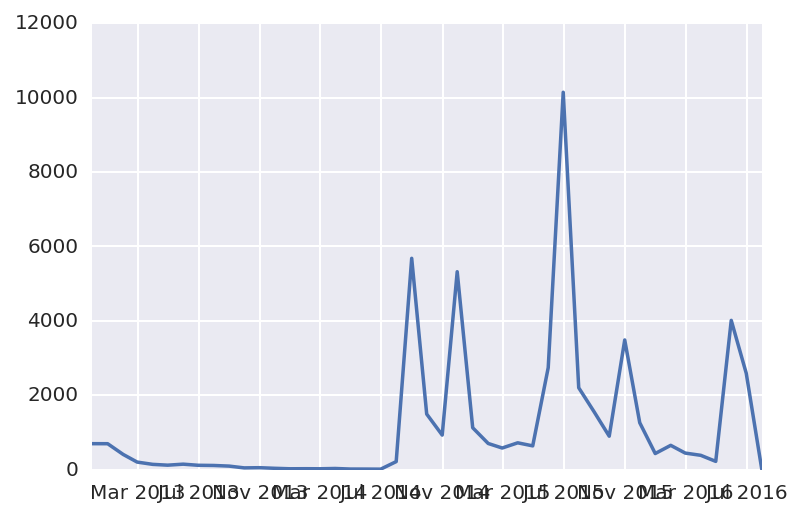

In [688]:
plot(x,y2)